<a href="https://colab.research.google.com/github/TamandaCodes/BrodgarFNO/blob/main/Brodgar_Data_Inspection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 03 version: Using neural op fno library


#### FNO input and data loading

In [3]:
# MOUNT THE DRIVE!!!
import os, sys
from google.colab import drive

drive_name = '/content/gdrive'
if os.path.ismount(drive_name):
    print(f'Drive ({drive_name}) already mounted')
else:
    drive.mount(drive_name)

# Project dir (where artifacts & outputs will be written)
dir_path = '/content/gdrive/MyDrive/Colab Notebooks/FourierNeuralOperator/Transient Folder'
os.makedirs(dir_path, exist_ok=True)
sys.path.insert(1, dir_path)


Drive (/content/gdrive) already mounted


In [16]:
import os
import math
import torch
import torch.nn as nn
import torch.fft as fft
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from typing import Tuple, Dict, Any
import numpy as np
from data_store_load import load_full_dataset
from fno_implementation_modified import (
    compute_norm_stats, FNO2DSpacetime, OneStepDataset,
    collate_batch, train_one_epoch, eval_one_epoch, autoregressive_rollout
)

In [4]:
# =========================
# Root dir & path helpers
# =========================
try:
    DIR = dir_path
except Exception:
    DIR = ""

def P(fn: str) -> str:
    "Join to project directory for outputs/artifacts."
    return os.path.join(DIR, fn)

def find_input(filename: str) -> str:
    cands = [
        os.path.join(DIR, filename),
        os.path.join('/mnt/data', filename),
        filename,  # absolute / custom
    ]
    for p in cands:
        if os.path.exists(p):
            return p
    raise FileNotFoundError(f"Could not find input file '{filename}' in {cands}")


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# =============================================================================
# CONFIGURATION - EDIT THESE
# =============================================================================
# ---- Configuration ----
IN_CHANNELS = 10   # All 10 variables as input
OUT_CHANNELS = 7   # First 7 variables as output

# ---- paths ----
dataset_file = find_input("cleaned_tensor.pt")
print(f"\n1. Configuration")
print(f"   Dataset file: {dataset_file}")
print(f"   Input channels: {IN_CHANNELS}")
print(f"   Output channels: {OUT_CHANNELS}")

# ---- check if dataset exists ----
if not os.path.exists(dataset_file):
    print(f"\n❌ Error: Dataset file not found: {dataset_file}")
    print("   Please run data_store_load.py first to create the dataset.")
    # return # Return None if dataset not found

  # ---- load dataset ----
print(f"\n2. Loading dataset...")
try:
    # Load your tensor format
    data = torch.load(dataset_file)

    # Handle different possible formats
    if isinstance(data, dict):
        full_tensor = data['full_tensor']  # [50, 1279, 10, 288]
        variable_names = data.get('variable_names', [f'Var{i}' for i in range(IN_CHANNELS)])
    else:
        full_tensor = data
        variable_names = [f'Var{i}' for i in range(IN_CHANNELS)]

    N, X, C, T = full_tensor.shape

    print(f"   ✓ Dataset shape: {full_tensor.shape}")
    print(f"   ✓ Cases: {N}")
    print(f"   ✓ Sections: {X}")
    print(f"   ✓ Variables: {C}")
    print(f"   ✓ Timesteps: {T}")
    print(f"   ✓ Variable names: {variable_names}")

    # Validate dimensions
    assert C >= IN_CHANNELS, f"Expected at least {IN_CHANNELS} channels, got {C}"
    assert C >= OUT_CHANNELS, f"Expected at least {OUT_CHANNELS} channels, got {C}"

except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    #return # Return None if error loading dataset


1. Configuration
   Dataset file: /content/gdrive/MyDrive/Colab Notebooks/FourierNeuralOperator/Transient Folder/cleaned_tensor.pt
   Input channels: 10
   Output channels: 7

2. Loading dataset...
   ✓ Dataset shape: torch.Size([50, 1279, 10, 288])
   ✓ Cases: 50
   ✓ Sections: 1279
   ✓ Variables: 10
   ✓ Timesteps: 288
   ✓ Variable names: ['PT', 'TM', 'HOL', 'HOLWT', 'UG', 'UL', 'ULWT', 'TT', 'PI', 'FI']


In [6]:
# =============================================================================
# 1. LOAD AND INSPECT DATA
# =============================================================================
# print("\n" + "="*70)
# print("LOADING DATA")
# print("="*70)

print(f"✓ Data loaded successfully!")
print(f"✓ Data type: {type(full_tensor)}")
print(f"✓ Data shape: {full_tensor.shape}")
print(f"✓ Data dtype: {full_tensor.dtype}")

# Verify dimensions
n_cases, n_sections, n_vars, n_timesteps = full_tensor.shape
print(f"\n📊 DIMENSION BREAKDOWN:")
print(f"  • Cases (scenarios):     {n_cases}")
print(f"  • Sections (spatial):    {n_sections}")
print(f"  • Variables (channels):  {n_vars}")
print(f"  • Timesteps (temporal):  {n_timesteps}")

✓ Data loaded successfully!
✓ Data type: <class 'torch.Tensor'>
✓ Data shape: torch.Size([50, 1279, 10, 288])
✓ Data dtype: torch.float32

📊 DIMENSION BREAKDOWN:
  • Cases (scenarios):     50
  • Sections (spatial):    1279
  • Variables (channels):  10
  • Timesteps (temporal):  288


###  Data Reshaping



UNDERSTANDING YOUR DATA DIMENSIONS


/tmp/ipython-input-687810418.py:99: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-687810418.py:99: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()


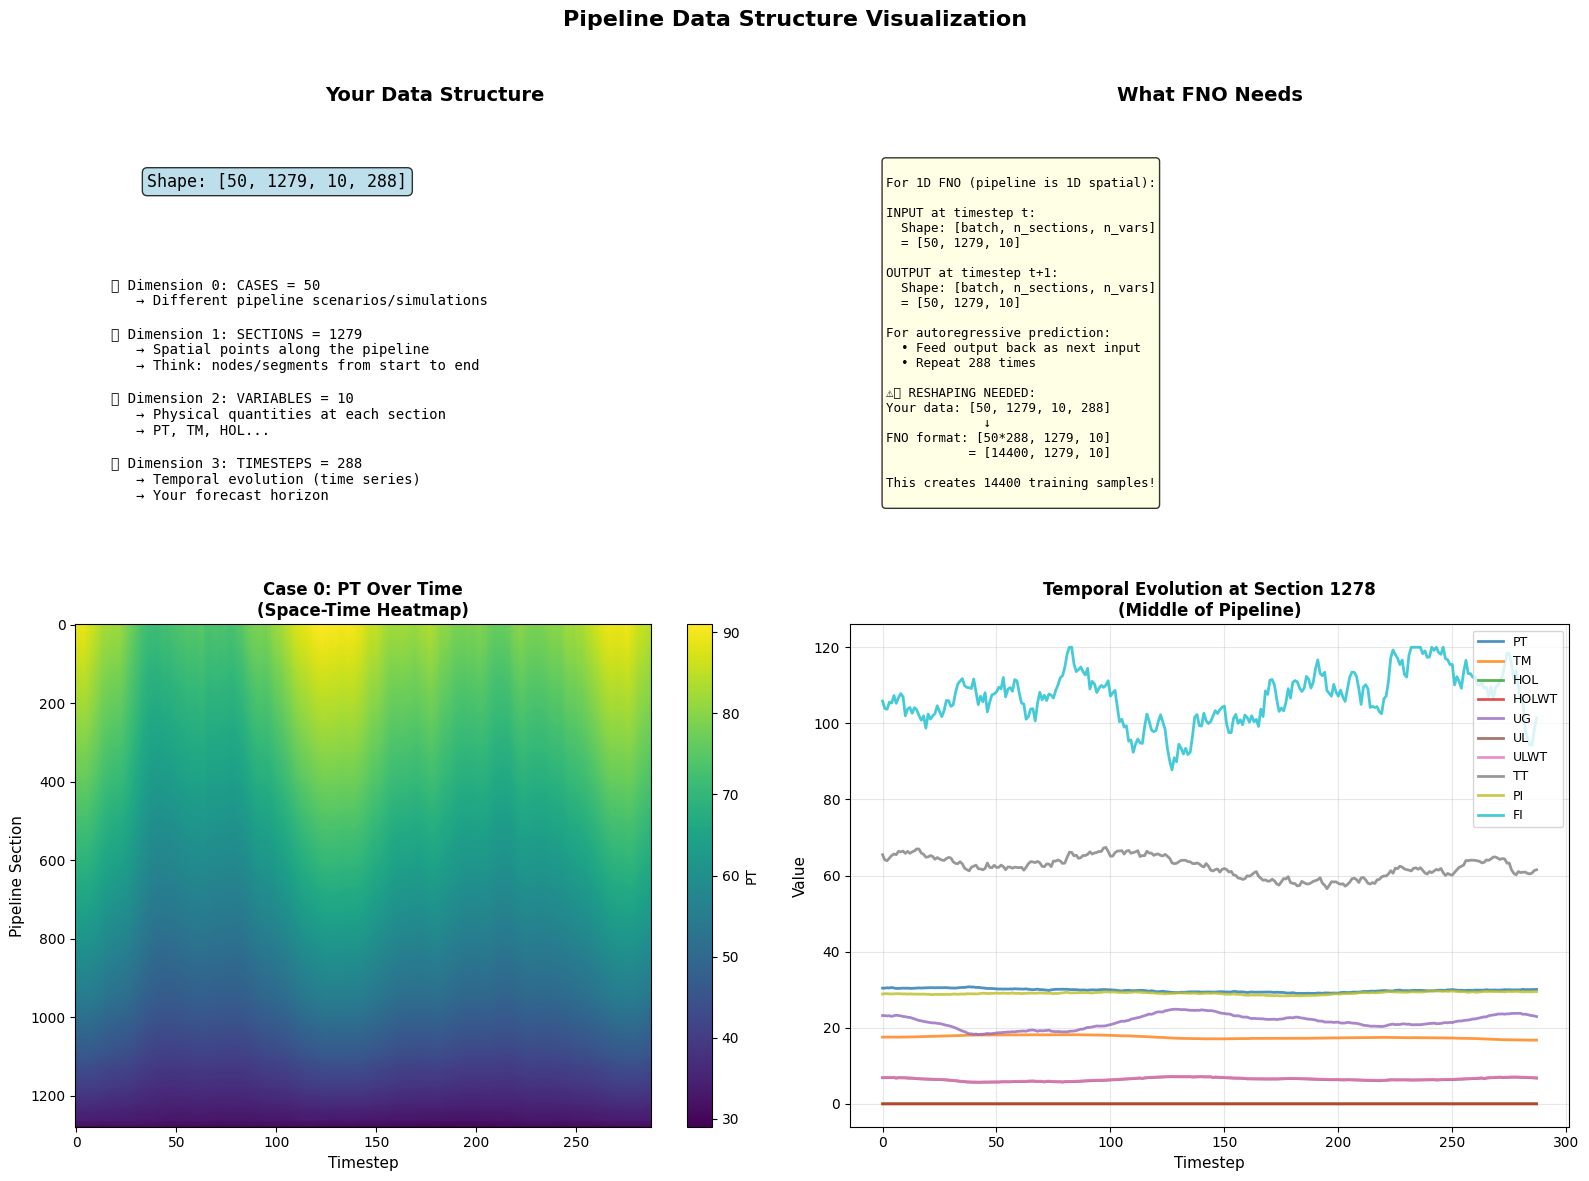

In [15]:
# =============================================================================
# 2. DIMENSION VISUALIZATION
# =============================================================================
print("\n" + "="*70)
print("UNDERSTANDING YOUR DATA DIMENSIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Pipeline Data Structure Visualization', fontsize=16, fontweight='bold')

# 2.1 - Visual representation of data structure
ax = axes[0, 0]
ax.text(0.5, 0.9, 'Your Data Structure', ha='center', va='top',
        fontsize=14, fontweight='bold', transform=ax.transAxes)
ax.text(0.1, 0.7, f'Shape: [{n_cases}, {n_sections}, {n_vars}, {n_timesteps}]',
        fontsize=12, transform=ax.transAxes, family='monospace',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

structure_text = f"""
🔹 Dimension 0: CASES = {n_cases}
   → Different pipeline scenarios/simulations

🔹 Dimension 1: SECTIONS = {n_sections}
   → Spatial points along the pipeline
   → Think: nodes/segments from start to end

🔹 Dimension 2: VARIABLES = {n_vars}
   → Physical quantities at each section
   → {', '.join(variable_names[:3])}...

🔹 Dimension 3: TIMESTEPS = {n_timesteps}
   → Temporal evolution (time series)
   → Your forecast horizon
"""
ax.text(0.05, 0.55, structure_text, fontsize=10, transform=ax.transAxes,
        verticalalignment='top', family='monospace')
ax.axis('off')

# 2.2 - What FNO expects
ax = axes[0, 1]
ax.text(0.5, 0.9, 'What FNO Needs', ha='center', va='top',
        fontsize=14, fontweight='bold', transform=ax.transAxes)

fno_text = f"""
For 1D FNO (pipeline is 1D spatial):

INPUT at timestep t:
  Shape: [batch, n_sections, n_vars]
  = [{n_cases}, {n_sections}, {n_vars}]

OUTPUT at timestep t+1:
  Shape: [batch, n_sections, n_vars]
  = [{n_cases}, {n_sections}, {n_vars}]

For autoregressive prediction:
  • Feed output back as next input
  • Repeat 288 times

⚠️ RESHAPING NEEDED:
Your data: [{n_cases}, {n_sections}, {n_vars}, {n_timesteps}]
             ↓
FNO format: [{n_cases}*{n_timesteps}, {n_sections}, {n_vars}]
           = [{n_cases * n_timesteps}, {n_sections}, {n_vars}]

This creates {n_cases * n_timesteps} training samples!
"""
ax.text(0.05, 0.75, fno_text, fontsize=9, transform=ax.transAxes,
        verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
ax.axis('off')

# 2.3 - Sample data visualization (first case, first variable)
ax = axes[1, 0]
sample_case = 0
sample_var = 0
sample_data = full_tensor[sample_case, :, sample_var, :].cpu().numpy()

im = ax.imshow(sample_data, aspect='auto', cmap='viridis', interpolation='nearest')
ax.set_xlabel('Timestep', fontsize=11)
ax.set_ylabel('Pipeline Section', fontsize=11)
ax.set_title(f'Case {sample_case}: {variable_names[sample_var]} Over Time\n(Space-Time Heatmap)',
             fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax, label=variable_names[sample_var])

# 2.4 - Temporal evolution at one section
ax = axes[1, 1]
sample_section = 1278 #n_sections // 2  # Middle of pipeline
for var_idx in range(min(10, n_vars)):  # Plot first 5 variables
    temporal_data = full_tensor[sample_case, sample_section, var_idx, :].cpu().numpy()
    ax.plot(temporal_data, label=variable_names[var_idx], linewidth=2, alpha=0.8)

ax.set_xlabel('Timestep', fontsize=11)
ax.set_ylabel('Value', fontsize=11)
ax.set_title(f'Temporal Evolution at Section {sample_section}\n(Middle of Pipeline)',
             fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# =============================================================================
# 3. DATA QUALITY CHECKS
# =============================================================================
print("\n" + "="*70)
print("DATA QUALITY INSPECTION")
print("="*70)

# Check for NaN/Inf
n_nan = torch.isnan(full_tensor).sum().item()
n_inf = torch.isinf(full_tensor).sum().item()
print(f"\n🔍 Missing/Invalid Values:")
print(f"  • NaN values: {n_nan}")
print(f"  • Inf values: {n_inf}")
if n_nan > 0 or n_inf > 0:
    print("  ⚠️  WARNING: Found invalid values! Clean your data before training.")
else:
    print("  ✓ No invalid values found")

# Statistics per variable
print(f"\n📈 Statistics Per Variable:")
print(f"{'Variable':<15} {'Min':<12} {'Max':<12} {'Mean':<12} {'Std':<12}")
print("-" * 70)
for var_idx in range(n_vars):
    var_data = full_tensor[:, :, var_idx, :]
    print(f"{variable_names[var_idx]:<15} "
          f"{var_data.min().item():<12.4f} "
          f"{var_data.max().item():<12.4f} "
          f"{var_data.mean().item():<12.4f} "
          f"{var_data.std().item():<12.4f}")

 # ---- splits (by case) ----
print(f"\n3. Creating train/val/test splits...")
N = full_tensor.shape[0]
n_train = int(0.8 * N)
n_val   = int(0.1 * N)
n_test  = N - n_train - n_val

print(f"   Total cases: {N}")
print(f"   Train: {n_train} cases ({100*n_train/N:.0f}%)")
print(f"   Val: {n_val} cases ({100*n_val/N:.0f}%)")
print(f"   Test: {n_test} cases ({100*n_test/N:.0f}%)")

  # simple contiguous split; switch to random if you prefer
train_tensor = full_tensor[:n_train]
val_tensor   = full_tensor[n_train:n_train+n_val]
test_tensor  = full_tensor[n_train+n_val:]

# Normalize
print(f"\n4. Computing normalization statistics...")
mean_input, std_input, mean_output, std_output = compute_norm_stats(
    train_tensor, IN_CHANNELS, OUT_CHANNELS
)

print("   Input variables (10):")
for i in range(IN_CHANNELS):
    var_name = variable_names[i] if i < len(variable_names) else f'Var{i}'
    print(f"     {var_name}: mean={mean_input[i]:.3e}, std={std_input[i]:.3e}")

print("   Output variables (7):")
for i in range(OUT_CHANNELS):
    var_name = variable_names[i] if i < len(variable_names) else f'Var{i}'
    print(f"     {var_name}: mean={mean_output[i]:.3e}, std={std_output[i]:.3e}")

# Temporal consistency check
print(f"\n⏱️  Temporal Consistency:")
temporal_diff = torch.diff(full_tensor, dim=3).abs().mean()
print(f"  • Average absolute change per timestep: {temporal_diff.item():.6f}")
if temporal_diff > 1.0:
    print("  ⚠️  Large timestep changes detected - data might be noisy")
else:
    print("  ✓ Temporal changes are smooth")


DATA QUALITY INSPECTION

🔍 Missing/Invalid Values:
  • NaN values: 0
  • Inf values: 0
  ✓ No invalid values found

📈 Statistics Per Variable:
Variable        Min          Max          Mean         Std         
----------------------------------------------------------------------
PT              29.0100      105.6910     53.8628      16.9955     
TM              8.5210       69.9420      38.0510      12.7658     
HOL             0.0000       0.6420       0.1257       0.0313      
HOLWT           0.0000       0.5490       0.0708       0.0290      
UG              0.0000       26.9730      7.3838       2.3931      
UL              -1.9470      12.2170      2.5043       0.9398      
ULWT            -2.1800      12.1970      2.0983       0.9171      
TT              50.0000      70.0000      60.6922      5.6281      
PI              28.0000      30.0000      28.9489      0.5911      
FI              20.0000      120.0000     75.1278      28.2984     

3. Creating train/val/test splits...

In [24]:
# =============================================================================
# 4. DATA RESHAPING HELPER
# =============================================================================
print("\n" + "="*70)
print("DATA RESHAPING FOR FNO TRAINING")
print("="*70)

def prepare_fno_sequences(full_tensor, history_steps=1):
    """
    Reshape data for FNO training.

    Args:
        data: [n_cases, n_sections, n_vars, n_timesteps]
        history_steps: number of previous timesteps to use as input

    Returns:
        X: inputs [n_samples, n_sections, n_vars * history_steps]
        y: targets [n_samples, n_sections, n_vars]
    """
    n_cases, n_sections, n_vars, n_timesteps = full_tensor.shape

    X_list = []
    y_list = []

    for case_idx in range(n_cases):
        for t in range(history_steps, n_timesteps):
            # Input: previous history_steps
            x = full_tensor[case_idx, :, :, t-history_steps:t]  # [n_sections, n_vars, history_steps]
            x = x.permute(0, 2, 1).reshape(n_sections, -1)  # [n_sections, n_vars*history_steps]

            # Target: next timestep
            y = full_tensor[case_idx, :, :, t]  # [n_sections, n_vars]

            X_list.append(x)
            y_list.append(y)

    X = torch.stack(X_list)  # [n_samples, n_sections, n_vars*history_steps]
    y = torch.stack(y_list)  # [n_samples, n_sections, n_vars]

    return X, y

# Create example with 1 history step (standard teacher forcing)
print("\n📦 Creating training sequences (1-step prediction)...")
X_train, y_train = prepare_fno_sequences(full_tensor, history_steps=1)
print(f"  ✓ Input shape (X):  {X_train.shape}  <- This goes into FNO")
print(f"  ✓ Target shape (y): {y_train.shape}  <- This is what FNO should predict")
print(f"  ✓ Total training samples: {X_train.shape[0]}")


DATA RESHAPING FOR FNO TRAINING

📦 Creating training sequences (1-step prediction)...
  ✓ Input shape (X):  torch.Size([14350, 1279, 10])  <- This goes into FNO
  ✓ Target shape (y): torch.Size([14350, 1279, 10])  <- This is what FNO should predict
  ✓ Total training samples: 14350



EXAMPLE TRAINING SAMPLE


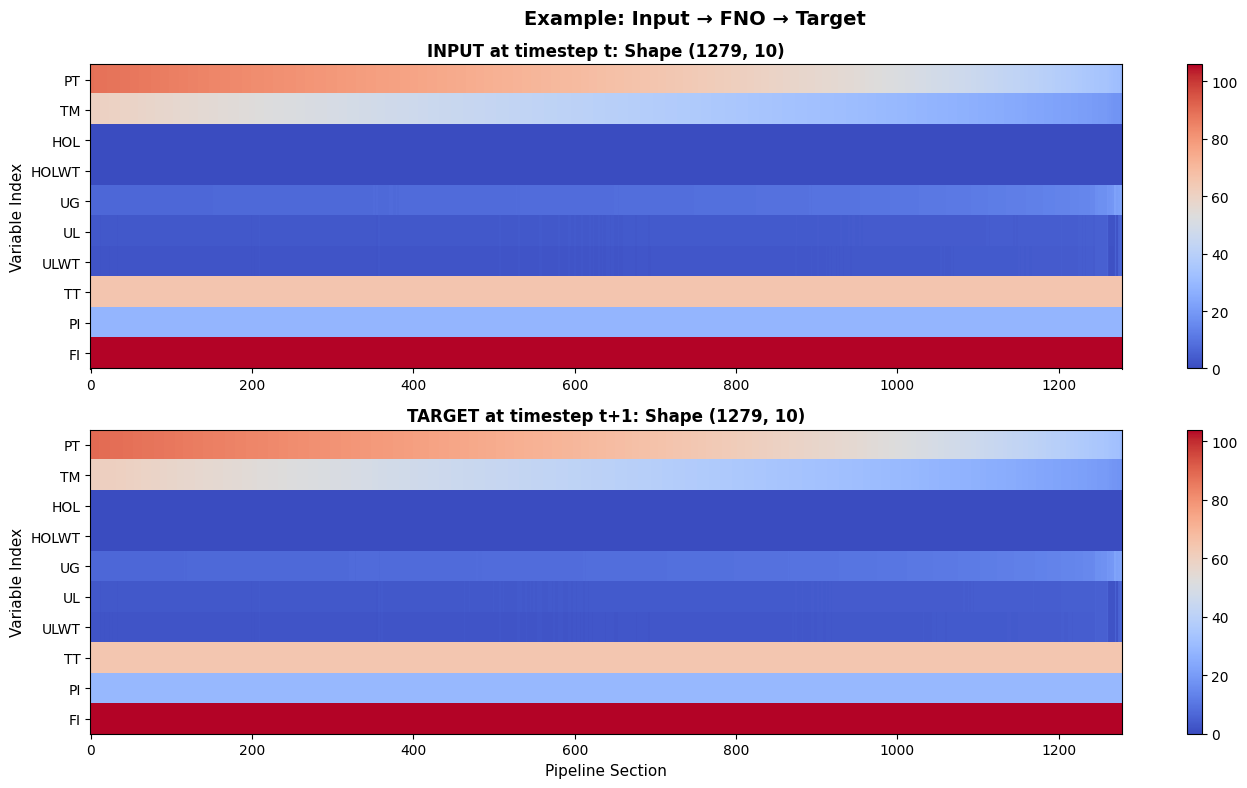


✅ Data inspection complete!

💡 NEXT STEPS:
  3. Use X_train and y_train format for your FNO model
  4. For autoregressive rollout, feed predictions back as inputs


In [25]:
# =============================================================================
# 5. SAMPLE VISUALIZATION FOR ONE TRAINING PAIR
# =============================================================================
print("\n" + "="*70)
print("EXAMPLE TRAINING SAMPLE")
print("="*70)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))
fig.suptitle('Example: Input → FNO → Target', fontsize=14, fontweight='bold')

sample_idx = 0
input_sample = X_train[sample_idx].cpu().numpy()  # [n_sections, n_vars]
target_sample = y_train[sample_idx].cpu().numpy()  # [n_sections, n_vars]

# Input
ax = axes[0]
im = ax.imshow(input_sample.T, aspect='auto', cmap='coolwarm', interpolation='nearest')
ax.set_ylabel('Variable Index', fontsize=11)
ax.set_title(f'INPUT at timestep t: Shape {input_sample.shape}', fontsize=12, fontweight='bold')
ax.set_yticks(range(n_vars))
ax.set_yticklabels(variable_names)
plt.colorbar(im, ax=ax)

# Target
ax = axes[1]
im = ax.imshow(target_sample.T, aspect='auto', cmap='coolwarm', interpolation='nearest')
ax.set_xlabel('Pipeline Section', fontsize=11)
ax.set_ylabel('Variable Index', fontsize=11)
ax.set_title(f'TARGET at timestep t+1: Shape {target_sample.shape}', fontsize=12, fontweight='bold')
ax.set_yticks(range(n_vars))
ax.set_yticklabels(variable_names)
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

print("\n✅ Data inspection complete!")
print("\n💡 NEXT STEPS:")
# print("  1. If normalization needed, apply it before training")
# print("  2. Split into train/val/test sets (e.g., 40/5/5 cases)")
print("  3. Use X_train and y_train format for your FNO model")
print("  4. For autoregressive rollout, feed predictions back as inputs")